<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> Gradient Boost Classification</p>

*Approach*
1. Load data
2. Split data
3. Create ColumnTransformer w/ ohe (so scaling needed)
4. Create GradientBoostClassifier w/ default
5. Create pipeline w/ ColumnTransformer and GradientBoostClassifier
6. Create and evaluate cross_val_score on pipeline
7. Compare train and test scores for baseline model
8. Compare affect of different seeds on baseline model. Verify cross_val_score and test averages are similar
9. Create GridSearchCV with params 
10. Fit and evaluate best hyperparameters
11. Plot classification_report and confusion_matrix
12. Evaluate affect of balancing the class with smote or with class_weight="balanced" 


*Import Libraries*

In [4]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC


# import others
import os
import pickle
import warnings

# Specific warning categories to be ignored
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

*Import data from initial EDA*

In [2]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


*Split data and prepare labels*

In [3]:
ALL_FEATURES = ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 
                'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 
                'Daily Steps', 'Blood Pressure Category']
X = df[ALL_FEATURES]
y = df[settings.LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# check new values in consolidated column
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])

# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

*Preprocess steps*

In [5]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# Check ohe and scaled datasets
display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

'train: check for dummy encoded columns and scaled values (mean 0 and std 1)'

(261, 23)

,Gender_Female,Gender_Male,Occupation_Accountant,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,Occupation_Nurse,Occupation_Salesperson,Occupation_Teacher,Occupation_Unknown,BMI Category_Normal,BMI Category_Overweight,Blood Pressure Category_Elevated,Blood Pressure Category_High Blood Pressure Stage 1,Blood Pressure Category_High Blood Pressure Stage 2,Blood Pressure Category_Normal,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
mean,0.494253,0.505747,0.103448,0.183908,0.176245,0.126437,0.183908,0.084291,0.111111,0.030651,0.582375,0.417625,0.318008,0.375479,0.187739,0.118774,42.145594,7.135249,7.298851,59.996169,5.409962,70.122605,6868.582375
std,0.500928,0.500928,0.305129,0.388153,0.381761,0.332979,0.388153,0.278358,0.314873,0.172702,0.494115,0.494115,0.466597,0.485177,0.391254,0.324144,8.520669,0.784797,1.187579,20.718163,1.746573,4.044025,1621.398228


'test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)'

(113, 23)

,Gender_Female,Gender_Male,Occupation_Accountant,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,Occupation_Nurse,Occupation_Salesperson,Occupation_Teacher,Occupation_Unknown,BMI Category_Normal,BMI Category_Overweight,Blood Pressure Category_Elevated,Blood Pressure Category_High Blood Pressure Stage 1,Blood Pressure Category_High Blood Pressure Stage 2,Blood Pressure Category_Normal,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
mean,0.495575,0.504425,0.088496,0.203540,0.150442,0.123894,0.221239,0.088496,0.097345,0.026549,0.566372,0.433628,0.353982,0.345133,0.212389,0.088496,42.274336,7.124779,7.345133,57.265487,5.327434,70.265487,6697.345133
std,0.502208,0.502208,0.285279,0.404424,0.359097,0.330928,0.416930,0.285279,0.297748,0.161476,0.497783,0.497783,0.480334,0.477529,0.410821,0.285279,9.053657,0.823704,1.223066,21.057327,1.844115,4.356886,1610.648726


*Create pipeline and base model*

In [7]:
# create gradient boosting model
model_gb = GradientBoostingClassifier(random_state=42)

#create sklearn pipeline
pipeline_gb = settings.create_pipeline(["preprocess", column_trans], ["gradientboost", model_gb])

# create cross validation object for cross_val_score
cv_gb = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# define custom scorer for this work: positive label (class 1 and 2) F1 score
base_scorer = settings.CustomPositiveF1Scorer().scorer_function
custom_scorer = settings.CustomPositiveF1Scorer().custom_scorer

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_gb, X_train, y_train, scoring=custom_scorer, cv=cv_gb)

settings.cross_val_summary(pipeline_gb, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)


Train Score: 90.141 %
Mean CV Train Score: 80.0779 % ( +- 4.400 % )
Test Score: 81.250 %



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97        66
           1       0.83      0.79      0.81        24
           2       0.77      0.87      0.82        23

    accuracy                           0.90       113
   macro avg       0.86      0.87      0.86       113
weighted avg       0.91      0.90      0.90       113



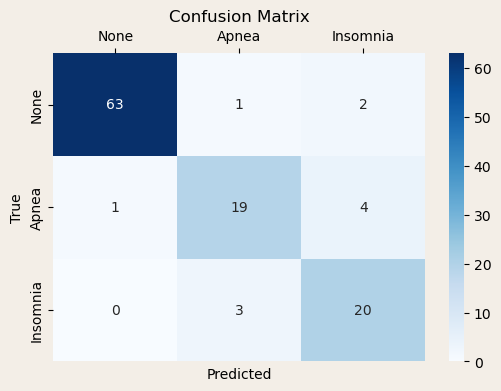

In [8]:
pipeline_gb.fit(X_train, y_train)

# Generate prediction and show classification report
y_pred = pipeline_gb.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Decent baseline cross validated F1 score 80.1% and slightly higher test accuracy 81.3%. Train score is much higher at 90.1% showing overfitting.</li>
    <li>Variation in cross validated scores is lower than other models, notably the single models, but still high (4.4%)</li>
    <li>Overall model accuracy is high at ~ 90%.</li>
    <li>The model has most difficulty separating the two positive classes: almost equal impact in their recalls through misclassification both ways. Let's see if tuning can move some of the misclassified Insomnia and Apnea samples to their true labels.
</ul>
</div>


In [9]:
# Save baseline pipeline to file  
settings.save_pipeline("best_gradient_boost_classification_pipeline.pkl", pipeline_gb)

*Hyperparam tuning*

In [12]:
# set up param grid
param_grid_gb = {
    'gradientboost__n_estimators': [10, 50, 100, 200, 500],
    'gradientboost__max_depth': [3, 5, 7, 9, 11],
    'gradientboost__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

# Create and fit GridSearchCV object on train data
grid_search_gb = GridSearchCV(pipeline_gb, param_grid=param_grid_gb, scoring=custom_scorer, cv=cv_gb, n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_gb, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,gradientboost__max_depth,gradientboost__n_estimators,gradientboost__subsample
0,3,10,0.8


---------------------
Using best parameters
---------------------
Train Score: 89.202 %
Mean CV Train Score: 82.152 % ( +- 5.926 % )
Test Score: 82.979 %


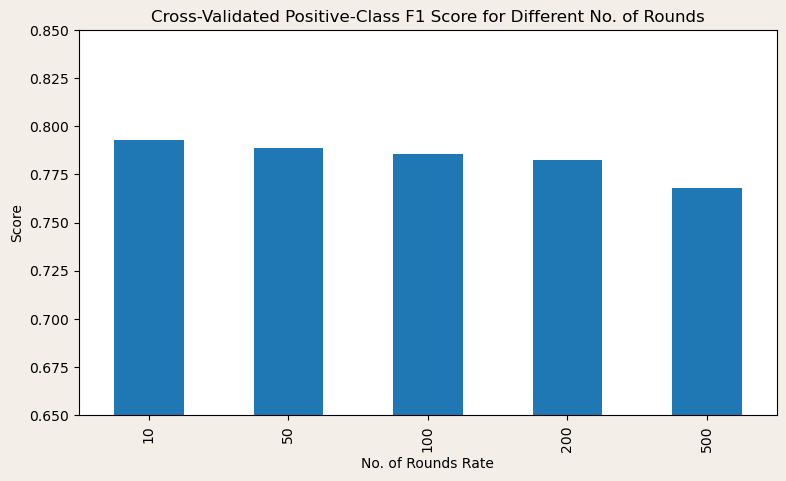

In [24]:
# Access the grid search results
results = grid_search_gb.cv_results_

# Extract k values, weights values and accuracy scores
grouped = pd.DataFrame(results)
grouped = grouped.groupby("param_gradientboost__n_estimators")["mean_test_score"].mean()

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
grouped.plot(kind='bar', figsize=(9, 5), ax=ax)

# Add plot details
ax.set_ylim(0.65, 0.85)
ax.set_xlabel('No. of Rounds Rate')
ax.set_ylabel('Score')
ax.set_title('Cross-Validated Positive-Class F1 Score for Different No. of Rounds')
plt.show()

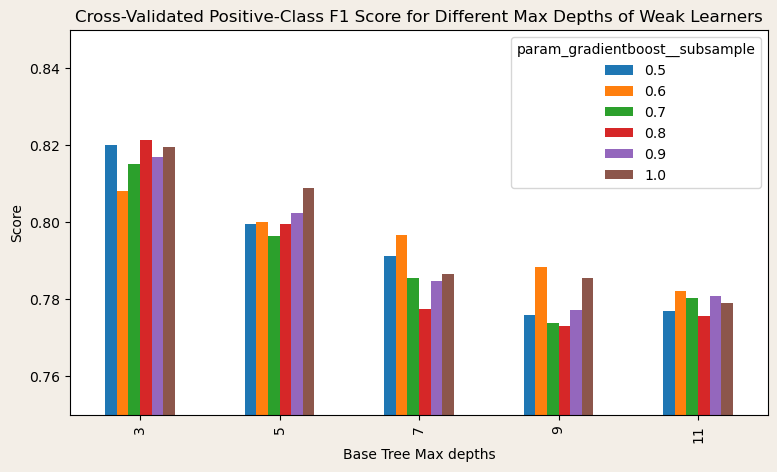

In [20]:
# Access the grid search results
results = grid_search_gb.cv_results_

# Extract k values, weights values and accuracy scores
grouped = pd.DataFrame(results)
grouped = grouped[grouped["param_gradientboost__n_estimators"]== 10]
grouped = grouped.groupby(["param_gradientboost__max_depth", "param_gradientboost__subsample"])["mean_test_score"].mean().unstack()

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
grouped.plot(kind='bar', figsize=(9, 5), ax=ax)

# Add plot details
ax.set_ylim(0.75, 0.85)
ax.set_xlabel('Base Tree Max depths')
ax.set_ylabel('Score')
ax.set_title('Cross-Validated Positive-Class F1 Score for Different Max Depths of Weak Learners')
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        66
           1       0.83      0.79      0.81        24
           2       0.83      0.87      0.85        23

    accuracy                           0.92       113
   macro avg       0.88      0.88      0.88       113
weighted avg       0.92      0.92      0.92       113



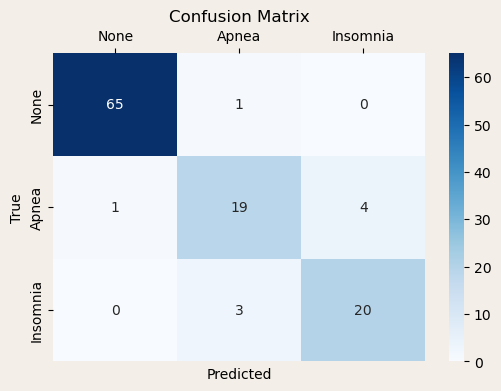

In [22]:
pipeline_gb = grid_search_gb.best_estimator_
pipeline_gb.fit(X_train, y_train)

# Generate prediction and show classification report
y_pred = pipeline_gb.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Hyperparam tuning improves results slightly.</li>
    <li>Cross validated F1 score decreases very slightly but consistently as number of boosting rounds increases from 10.</li>
    <li>At 10 rounds, score decreases consistently after a max tree depth of 3. For this tree depths, different subsample choices resulted in very similar scores with 0.8 marginally the best.</li>
    <li>Confusion matrix shows no improvement in separation of the two positive classes. However, separation between None and Insomnia has improved (less false positives for Insomnia coming from None).
    <li>This remains, however, below the scores of simplier models and other ensemble models.</li>
    <li>With more time, further feature engineering could be performed to improve the score.</li>     
</ul>
</div>


In [26]:
# Save baseline pipeline to file  
settings.save_pipeline("best_gradient_boost_classification_pipeline.pkl", pipeline_gb)

*Exploring SMOTE-NC for class imbalance*

In [27]:
# instantiate SMOTENC object with categorical indicies of transformed X_train dataset
categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# Proving smote object works using the X array transformed by column_trans
from collections import Counter
smote_x, smote_y = smote_nc.fit_resample(transformed_X_train_df, y_train)
print(f"Original class counts: {Counter(y_train)}")
print(f"New class counts: {Counter(smote_y)}")

Original class counts: Counter({0: 153, 2: 54, 1: 54})
New class counts: Counter({2: 153, 1: 153, 0: 153})


In [28]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# Check ohe and scaled datasets
# display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
# display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

In [31]:
# Set up pipeline using imblearn's Pipeline class (SMOTE not compatible with sklearn's Pipeline)
# Reuse model with tuned hyperparameters
steps = [('column_trans', column_trans), ('smote', smote_nc), ("gradientboost", model_gb)]
pipeline_gb = Pipeline_imb(steps)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_gb, X_train, y_train, scoring=custom_scorer, cv=cv_gb)

settings.cross_val_summary(pipeline_gb, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)


Train Score: 89.720 %
Mean CV Train Score: 80.7450 % ( +- 4.869 % )
Test Score: 82.105 %


*Hyperparam tuning*

In [32]:
# set up param grid
param_grid_gb = {
    'gradientboost__n_estimators': [10, 50, 100, 200, 500],
    'gradientboost__max_depth': [3, 5, 7, 9, 11],
    'gradientboost__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

# Create and fit GridSearchCV object on train data
grid_search_gb = GridSearchCV(pipeline_gb, param_grid=param_grid_gb, scoring=custom_scorer, cv=cv_gb, n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_gb, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,gradientboost__max_depth,gradientboost__n_estimators,gradientboost__subsample
0,3,10,0.7


---------------------
Using best parameters
---------------------
Train Score: 87.324 %
Mean CV Train Score: 82.795 % ( +- 6.371 % )
Test Score: 85.106 %
